In [1]:
!pip install timm
!pip install git+https://github.com/mapillary/inplace_abn.git@v1.0.12

     |████████████████████████████████| 346 kB 1.3 MB/s eta 0:00:01
  Cloning https://github.com/mapillary/inplace_abn.git (to revision v1.0.12) to /tmp/pip-req-build-9md3yolp
  Running command git clone -q https://github.com/mapillary/inplace_abn.git /tmp/pip-req-build-9md3yolp
  Running command git checkout -q 24fc791e6d4796a1639e7a5dce6fa67377e51a3e
  Created wheel for inplace-abn: filename=inplace_abn-1.0.12-cp37-cp37m-linux_x86_64.whl size=2760826 sha256=a2cc8c87dfc85a4da3d3cb80b789939afed516034f1b99b7529cb8cf3873a18b
  Stored in directory: /tmp/pip-ephem-wheel-cache-yk26mlm1/wheels/df/ad/aa/7ec1eff8c9b56fb3fab10471e91c80bdf3b52036bf47727bae
Successfully built inplace-abn


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/oxford-102-flower-pytorch/sample_submission.csv
/kaggle/input/oxford-102-flower-pytorch/flower_data.zip


In [3]:
!unzip /kaggle/input/oxford-102-flower-pytorch/flower_data.zip


Archive:  /kaggle/input/oxford-102-flower-pytorch/flower_data.zip
  inflating: flower_data/cat_to_name.json  
   creating: flower_data/test/
  inflating: flower_data/test/image_00005.jpg  
  inflating: flower_data/test/image_00006.jpg  
  inflating: flower_data/test/image_00024.jpg  
  inflating: flower_data/test/image_00025.jpg  
  inflating: flower_data/test/image_00029.jpg  
  inflating: flower_data/test/image_00050.jpg  
  inflating: flower_data/test/image_00060.jpg  
  inflating: flower_data/test/image_00065.jpg  
  inflating: flower_data/test/image_00092.jpg  
  inflating: flower_data/test/image_00099.jpg  
  inflating: flower_data/test/image_00114.jpg  
  inflating: flower_data/test/image_00116.jpg  
  inflating: flower_data/test/image_00132.jpg  
  inflating: flower_data/test/image_00176.jpg  
  inflating: flower_data/test/image_00177.jpg  
  inflating: flower_data/test/image_00187.jpg  
  inflating: flower_data/test/image_00191.jpg  
  inflating: flower_data/test/image_00202.j

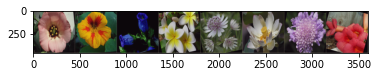

In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import timm


plt.ion()   # interactive mode

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((464,464)),
        transforms.RandomRotation(15,),
        transforms.RandomCrop(448),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((448,448)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}


data_dir = 'flower_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                   for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=0)
               for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x])  for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = 'cuda'#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)#, title=[class_names[x] for x in classes])


In [5]:
model_ft = timm.create_model("tresnet_xl", pretrained=True)
num_ftrs = model_ft.head.fc.in_features

half_in_size = num_ftrs
layer_width = 102
Num_class=102


class SpinalNetV1(nn.Module):
    def __init__(self):
        super(SpinalNetV1, self).__init__()
        self.dropout = nn.Dropout(p=0.2)      
        self.fc_spinal_layer1 = nn.Sequential(
            #nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size, layer_width),
            #nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer2 = nn.Sequential(
            #nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width*1, layer_width),
            #nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer3 = nn.Sequential(
            #nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width*2, layer_width),
            #nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer4 = nn.Sequential(
            #nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width*3, layer_width),
            #nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_out = nn.Sequential(
            #nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width*4, Num_class),)
        
    def forward(self, x):
      x = x.view(x.size()[0], -1)
      xOrgD = self.dropout(x)
      x1 = self.fc_spinal_layer1(x)
      xOrgD = torch.cat([xOrgD, x1], dim=1)
      x2 = self.fc_spinal_layer2(xOrgD)
      xOrgD = torch.cat([xOrgD, x2], dim=1)
      x3 = self.fc_spinal_layer3(xOrgD)
      xOrgD = torch.cat([xOrgD, x3], dim=1)
      x4 = self.fc_spinal_layer4(xOrgD)
      x = torch.cat([xOrgD, x4], dim=1)
      x = self.fc_out(x)
      return x  

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-tresnet/tresnet_xl_82_0-a2d51b00.pth" to /root/.cache/torch/hub/checkpoints/tresnet_xl_82_0-a2d51b00.pth


In [6]:
# # model_ft.layer1 = SpinalNet_ResNet() #SpinalNet_VGG
model_ft.head.fc = SpinalNetV1() 

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
 
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                time_elapsed = time.time() - since
                print('Time from Start {:.0f}m {:.0f}s'.format(
                    time_elapsed // 60, time_elapsed % 60))
                
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
valid Loss: 0.2302 Acc: 0.9487
Time from Start 12m 48s

Epoch 1/19
train Loss: 0.2782 Acc: 0.9370
valid Loss: 0.0993 Acc: 0.9756
Time from Start 25m 35s

Epoch 2/19
train Loss: 0.1114 Acc: 0.9741
valid Loss: 0.0996 Acc: 0.9817
Time from Start 38m 22s

Epoch 3/19
train Loss: 0.0688 Acc: 0.9855
valid Loss: 0.0845 Acc: 0.9804

Epoch 4/19
train Loss: 0.0425 Acc: 0.9918
valid Loss: 0.0592 Acc: 0.9914
Time from Start 63m 54s

Epoch 5/19
train Loss: 0.0339 Acc: 0.9927
valid Loss: 0.0586 Acc: 0.9939
Time from Start 76m 41s

Epoch 6/19
train Loss: 0.0265 Acc: 0.9954
valid Loss: 0.0512 Acc: 0.9914

Epoch 7/19
train Loss: 0.0187 Acc: 0.9973
valid Loss: 0.0442 Acc: 0.9914

Epoch 8/19
train Loss: 0.0141 Acc: 0.9983
valid Loss: 0.0397 Acc: 0.9927

Epoch 9/19
train Loss: 0.0132 Acc: 0.9986
valid Loss: 0.0416 Acc: 0.9951
Time from Start 127m 46s

Epoch 10/19
train Loss: 0.0116 Acc: 0.9985
valid Loss: 0.0408 Acc: 0.9939

Epoch 11/19
train Loss: 0.0119 Acc: 0.9983
valid Loss: 0.0382 Acc: 0.99

In [9]:
nb_classes = 102

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['valid']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[ 8.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  4.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  6.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  7.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0., 10.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  6.]])


Text(0.5, 159.0, 'Predicted label')

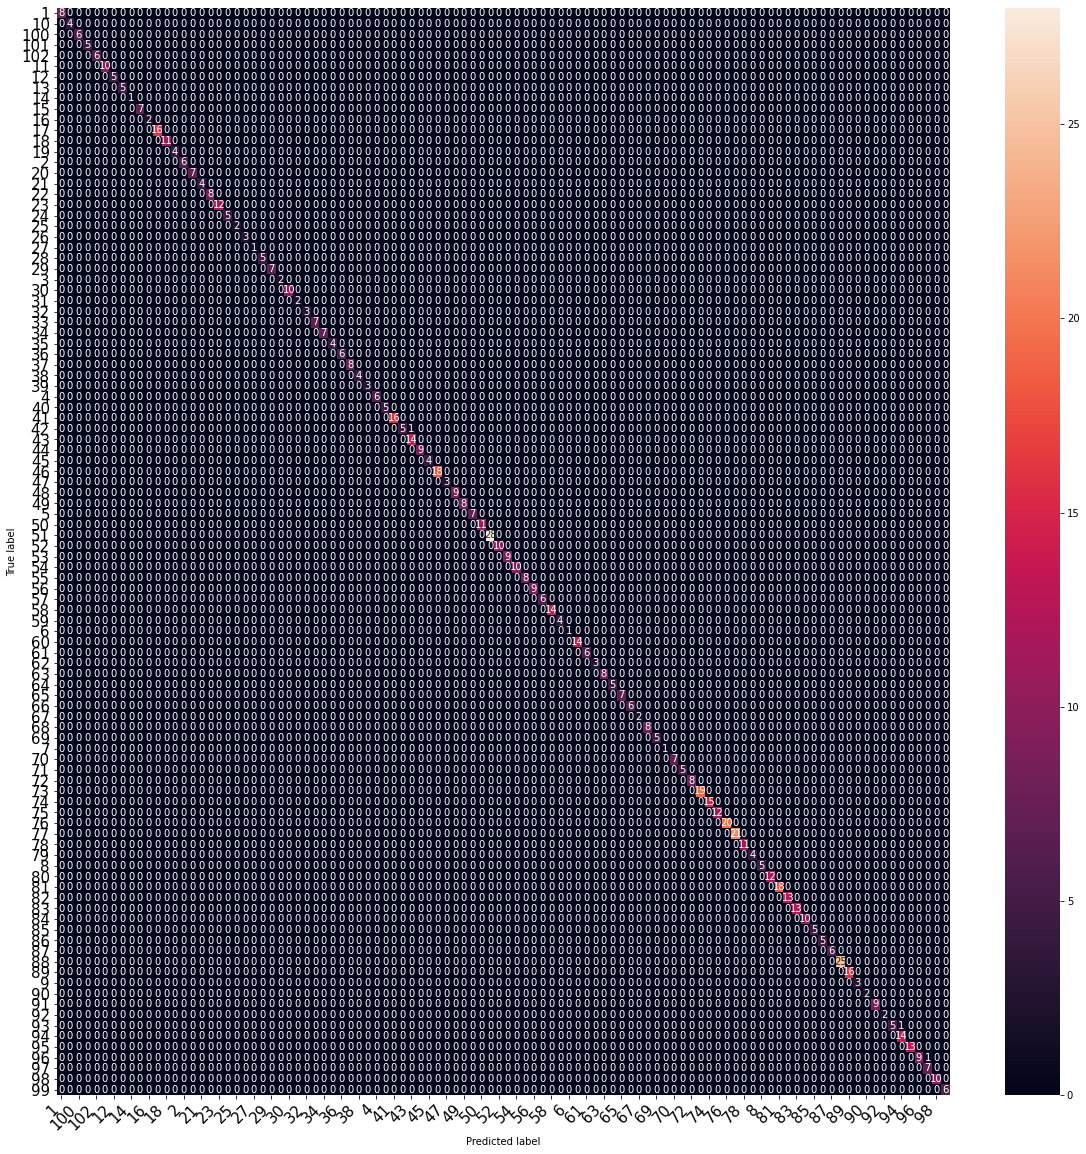

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns

plt.figure(figsize=(20,20))
class_names = list(image_datasets['valid'].classes)
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [11]:
recall = np.diag(df_cm) / np.sum(df_cm, axis = 1)
precision = np.diag(df_cm) / np.sum(df_cm, axis = 0)

In [12]:
print("Recall")
print(recall)
print(recall.mean())


print("\nPresisi")
print(precision)
print(precision.mean())

Recall
1      1.0
10     1.0
100    1.0
101    1.0
102    1.0
      ... 
95     1.0
96     0.9
97     1.0
98     1.0
99     1.0
Length: 102, dtype: float64
0.9957516339869281

Presisi
1      1.000
10     1.000
100    1.000
101    1.000
102    1.000
       ...  
95     1.000
96     1.000
97     0.875
98     1.000
99     1.000
Length: 102, dtype: float64
0.997467320261438


In [13]:
!pip install disarray

In [14]:
import disarray
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

print('accuracy: {:3f}'.format(accuracy(confusion_matrix)))
print('precision: {:3f}'.format(df_cm.da.precision.mean()))
print('recall: {:3f}'.format(df_cm.da.recall.mean()))
print('f1: {:3f}'.format(df_cm.da.f1.mean()))

accuracy: 0.996333
precision: 0.997467
recall: 0.995752
f1: 0.996372


In [15]:
!pip install openpyxl
df_cm.to_excel(' TS2_TResNet_Progressive Spinal Net_test_confusion_matrix.xlsx')

     |████████████████████████████████| 243 kB 1.2 MB/s eta 0:00:01
